In [63]:

# threshold
threshold_column_null = 0.63
threshold_k_bins = 30
discrete_threshold = 200
fillna_b_ = 0

# 0.5860
threshold_column_null = 0.63
threshold_k_bins = 30
discrete_threshold = 200
fillna_b_ = 0

# 0.5853
# threshold_column_null = 0.63
# threshold_k_bins = 30
# discrete_threshold = 200
# fillna_b_ = 10



In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from scipy.stats import entropy
from scipy.stats import ks_2samp
from sklearn import metrics
from eda_kit import conditional_entropy,roc_auc_score,auc



In [65]:
A_train = pd.read_csv('../data/A_train.csv')
B_train = pd.read_csv('../data/B_train.csv')
B_test = pd.read_csv('../data/B_test.csv')

a_data = A_train
b_data = B_train
test_data = B_test

print (a_data.dtypes[a_data.dtypes == np.int64])
print (b_data.dtypes[b_data.dtypes == np.int64])

no      int64
flag    int64
dtype: object
no              int64
flag            int64
UserInfo_170    int64
dtype: object


* 缺失值分析
    * https://blog.csdn.net/weixin_40159138/article/details/89421014
    * https://www.jianshu.com/p/9c867fb9cf17
    * https://scikit-learn.org/stable/modules/impute.html#impute
    * https://blog.csdn.net/qq_38958113/article/details/98220246
    * 从下图可以看到缺失值非常接近
    * B_test和A_train缺失值情况几乎一致
    * B_train的缺失值情况比A_train严重很多
    * A_train中20%的用户缺失维度在100个以内，40%的缺失维度在450个以上，60%用户的缺失维度在150个以内
    * B_train 和 B_test 38%的用户缺失维度在186左右，60%用户维度缺失在460以上
    * 缺失值在学习过程中，feature_importance 会降低，并不一定会影响学习效果，*可以对比是否填充缺失值对结果的影响*
    * 填充策略：
        * 离散值填充
        * 连续值填充
        * A的情况是正确的情况下，可以用于填充B的值，或者AB的分布，可以填充B_test的值
        * 对待缺失值不同的态度，为决定不同的填充策略：比如用户主动不填收入，那么这个null值应该赋予一个已有值之外的，比如特殊的-999
        * 对A值采取固定填充，但是可以对B采取transform的填充，
        * 填充时机？

/Users/wenqiang/opt/anaconda3/envs/qhzx37/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/Users/wenqiang/opt/anaconda3/envs/qhzx37/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/wenqiang/opt/anaconda3/envs/qhzx3

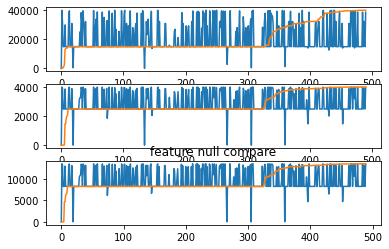

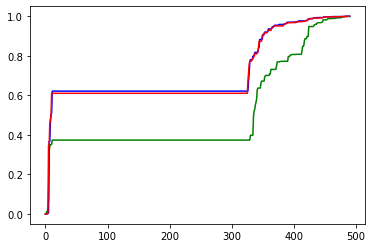

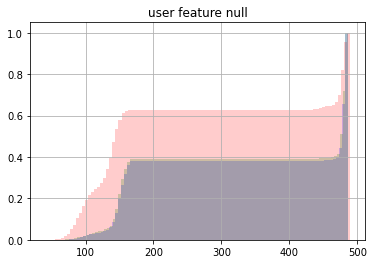

用户的维度缺失情况
0.602675
0.37875
0.38980910643987227


In [66]:
fea_null = np.sum(a_data.isnull(), axis=0)
feb_null = np.sum(b_data.isnull(), axis=0)
fet_null = np.sum(test_data.isnull(), axis=0)

plt.subplot(311).plot(fea_null.values)
plt.subplot(312).plot(feb_null.values)
plt.subplot(313).plot(fet_null.values)

# sort_values
plt.subplot(311).plot(np.sort(fea_null))
plt.subplot(312).plot(np.sort(feb_null))
plt.subplot(313).plot(np.sort(fet_null))
plt.title('feature null compare')
plt.show()

# 缺失值归一化
plt.plot(np.sort(fea_null/a_data.shape[0]), color='green')
plt.plot(np.sort(feb_null/b_data.shape[0]), color='blue')
plt.plot(np.sort(fet_null/test_data.shape[0]),color='red')
plt.show()

u_fea_null = np.sum(a_data.isnull(), axis=1)
u_feb_null = np.sum(b_data.isnull(), axis=1)
u_fet_null = np.sum(test_data.isnull(), axis=1)
u_fea_null.hist(cumulative=True, density=True, bins=100, alpha=.2, color="r")
u_feb_null.hist(cumulative=True, density=True, bins=100, alpha=.2, color="b")
u_fet_null.hist(cumulative=True, density=True, bins=100, alpha=.2, color="g")
plt.title('user feature null')
plt.show()
print( "用户的维度缺失情况")
print( (u_fea_null[u_fea_null<156].count()-0.0)/u_fea_null.count())
print( (u_feb_null[u_feb_null<186].count()-0.0)/u_feb_null.count())
print( (u_fet_null[u_fet_null<186].count()-0.0)/u_fet_null.count())

# 保留null值更少的维度
a_less_null_columns = fea_null[fea_null<a_data.shape[0]*threshold_column_null].sort_values(axis=0).index
b_less_null_columns = feb_null[feb_null<b_data.shape[0]*threshold_column_null].sort_values(axis=0).index
test_less_null_columns = fet_null[fet_null<test_data.shape[0]*threshold_column_null].sort_values(axis=0).index
a_b_less_null_columns = a_less_null_columns.intersection(b_less_null_columns)


* 连续与离散
    * 知识：https://blog.csdn.net/ztf312/article/details/53991329
    * https://blog.csdn.net/banbuduoyujian/article/details/53957653
    * https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html
    * https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.cut.html
    * https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing
    * https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization
    * 489维数据中，383维的取值在100个以内，推测大部分应该是离散值
    * 取值在100个以上的可能为连续值
    * 取值大于300的维度81个，大于500的69个，这些极可能是连续值
    * 需要对连续值进行离散化：分类

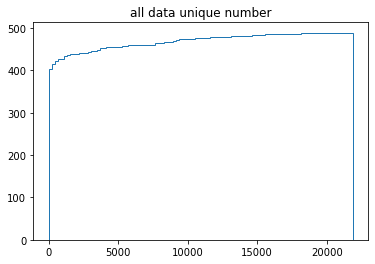

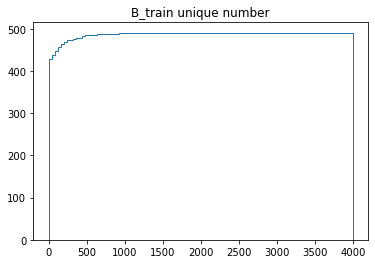

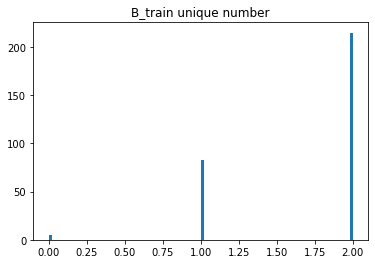

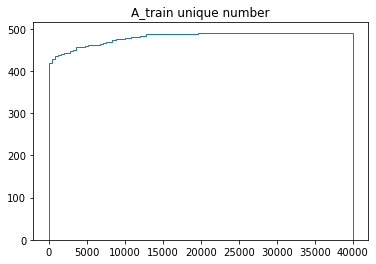

In [67]:
# 维度的取值个数，可以基本推断是连续值还是离散值
#对所有维度的所有取值计算取值数量
tmp_all_data = pd.concat([a_data.sort_index(axis=1).drop(['flag','no'],axis=1),b_data.sort_index(axis=1).drop(['flag','no'],axis=1)])
tmp_all_data = pd.concat([tmp_all_data, test_data.sort_index(axis=1).drop(['no'],axis=1)])
all_data_n_unique = tmp_all_data.nunique()
all_discrete_columns = all_data_n_unique[all_data_n_unique<=discrete_threshold].index
all_continuous_columns = all_data_n_unique[all_data_n_unique>discrete_threshold].index
plt.hist(all_data_n_unique, cumulative=True, histtype='step', bins=100);plt.title('all data unique number');plt.show()


# 有很多维度的取值个数只有0 或者 1，这些维度是没有太大意义的。可以通过离散值条件熵删选，这里先去掉这部分
# 为什么有取值为0的？？？
b_data_n_unique = b_data.nunique()
b_discrete_columns = b_data_n_unique[b_data_n_unique<=discrete_threshold].index
b_continuous_columns = b_data_n_unique[b_data_n_unique>discrete_threshold].index.drop('no')
b_discrete_columns = b_discrete_columns.drop(b_data_n_unique[b_data_n_unique<=1].index).drop('flag')
plt.hist(b_data_n_unique, cumulative=True, histtype='step', bins=100);plt.title('B_train unique number');plt.show()
plt.hist(b_data_n_unique, cumulative=False, histtype='bar', bins=100, range=[0,2]);plt.title('B_train unique number');plt.show()


a_data_n_unique = a_data.nunique()
a_discrete_columns = a_data_n_unique[a_data_n_unique<=discrete_threshold].index.drop('flag')
a_continuous_columns = a_data_n_unique[a_data_n_unique>discrete_threshold].index.drop('no')
a_discrete_columns = a_discrete_columns.drop(a_data_n_unique[a_data_n_unique<=1].index)
plt.hist(a_data_n_unique, cumulative=True, histtype='step', bins=100);plt.title('A_train unique number');plt.show()



all_data_n_unique.describe()
all_data_n_unique[b_continuous_columns].describe()
all_data_n_unique[a_continuous_columns].describe()

a_less_null_more_unique_columns = a_less_null_columns.intersection(a_discrete_columns.append(a_continuous_columns))
b_less_null_more_unique_columns = b_less_null_columns.intersection( b_discrete_columns.append(b_continuous_columns))
a_ln_mu_data = a_data[a_less_null_more_unique_columns.append(pd.Index(['no','flag']))]
b_ln_mu_data = b_data[b_less_null_more_unique_columns.append(pd.Index(['no','flag']))]
test_ln_mu_data = test_data[b_less_null_more_unique_columns.append(pd.Index(['no']))]

* 数据规范化
    * https://blog.csdn.net/weixin_38706928/article/details/80329563
    * https://scikit-learn.org/stable/modules/preprocessing.html

In [68]:

b_scaler = StandardScaler().fit(b_data[b_continuous_columns])
a_scaler = StandardScaler().fit(a_data[a_continuous_columns])

a_standard_data = a_ln_mu_data
b_standard_data = b_ln_mu_data
test_standard_data = test_ln_mu_data
a_standard_data[a_continuous_columns] = pd.DataFrame(a_scaler.transform(a_data[a_continuous_columns]), columns=a_continuous_columns)
b_standard_data[b_continuous_columns] = pd.DataFrame(b_scaler.transform(b_data[b_continuous_columns]),columns=b_continuous_columns)
test_standard_data[b_continuous_columns] = pd.DataFrame(b_scaler.transform(test_data[b_continuous_columns]),columns=b_continuous_columns)

# 填充null值
a_standard_fillna_data = a_standard_data.fillna(fillna_b_)
b_standard_fillna_data = b_standard_data.fillna(fillna_b_)
test_standard_fillna_data = test_standard_data.fillna(fillna_b_)

b_standard_fillna_data.to_csv('../data/B_train_standard_fillna.csv')
test_standard_fillna_data.to_csv('../data/B_test_standard_fillna.csv')

/Users/wenqiang/opt/anaconda3/envs/qhzx37/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/wenqiang/opt/anaconda3/envs/qhzx37/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/wenqiang/opt/anaconda3/envs/qhzx37/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

* 线性相关性
    * 剔除掉线性相关性大的维度
    * https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
    * 线性相关性强，但是条件熵小的维度是存在的：因为维度缺失很严重，如果填充值为0，那么向量很接近0向量
    * 综合分析，相关性非常强，很难删除

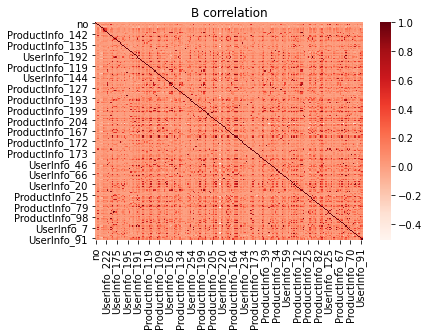

In [69]:
threshold_corr_bt = 0.98
b_sf_corr = b_standard_fillna_data.corr()
corr_length = b_sf_corr.shape[0]
final_cols_bt = []
del_cols_bt =[]
b_corr_big_columns = []
for i in range(corr_length):
    if b_sf_corr.columns[i] not in del_cols_bt:
        final_cols_bt.append(b_sf_corr.columns[i])
        for j in range(i+1,corr_length):
            if (b_sf_corr.iloc[i,j] > threshold_corr_bt) and (b_sf_corr.columns[j] not in del_cols_bt):
                b_corr_big_columns.append([b_sf_corr.columns[i],b_sf_corr.columns[j],b_sf_corr.iloc[i,j],i,j])
                del_cols_bt.append(b_sf_corr.columns[j])
b_corr_big_columns = pd.DataFrame(b_corr_big_columns, columns=['from','to','loc','i','j'])
b_corr_big_columns.to_csv('../data/b_corr_big_columns.csv')
b_less_corr_columns = a_b_less_null_columns.intersection(pd.Index(final_cols_bt))
b_less_corr_continuous_columns = b_less_corr_columns.intersection(b_continuous_columns)
b_less_corr_discrete_columns = b_less_corr_columns.intersection(b_discrete_columns)
sns.heatmap(b_standard_fillna_data[b_less_corr_columns].corr(), annot=False, cmap=plt.cm.Reds);plt.title('B correlation');plt.show()


* 同分布检验
    * https://blog.csdn.net/qq_41679006/article/details/80977113
    * https://www.cnblogs.com/arkenstone/p/5496761.html
    * https://blog.csdn.net/t15600624671/article/details/78770239
    * B_test 和 B_train只有2维数据的分布差异较大，显著性α=0.05
    * B_train 和 A_train的数据差异较大：有199维数据的分布相差大，所以考虑剔除掉199维数据
    * 缺失值少，且同分布的维度 极有可能是最重要的维度，可以尝试只取这部分数据进行分析， *可以做对比分析*
    * KS检验中d值，表示CDF中最大差异值。可以重点关注连续值中差异较小的值，这些值可以作为重点维度



                statistic        pvalue
UserInfo_200     0.160900  1.048030e-82
UserInfo_242     0.155225  5.646021e-77
UserInfo_253     0.114975  2.498967e-42
UserInfo_222     0.083925  9.969754e-23
UserInfo_180     0.142225  1.228944e-64
...                   ...           ...
UserInfo_95      0.002500  1.000000e+00
ProductInfo_71   0.071550  1.243899e-16
UserInfo_91      0.153325  4.203671e-75
ProductInfo_7    0.133800  3.156164e-57
UserInfo_10      0.023200  3.929573e-02

[205 rows x 2 columns]


/Users/wenqiang/opt/anaconda3/envs/qhzx37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/wenqiang/opt/anaconda3/envs/qhzx37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/wenqiang/opt/anaconda3/envs/qhzx37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (wh

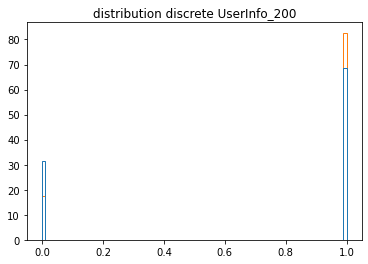

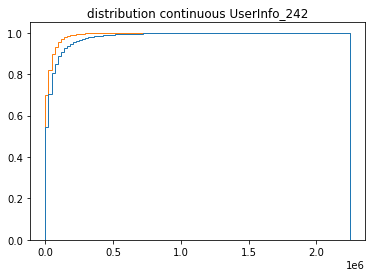

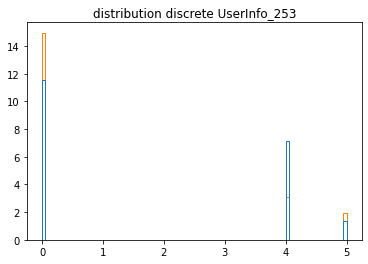

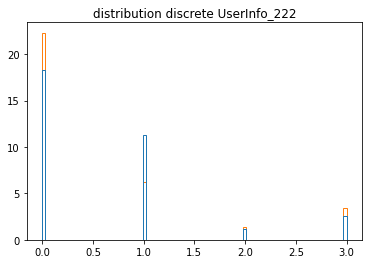

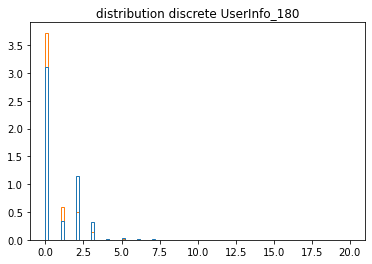

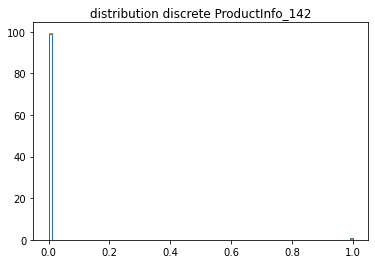

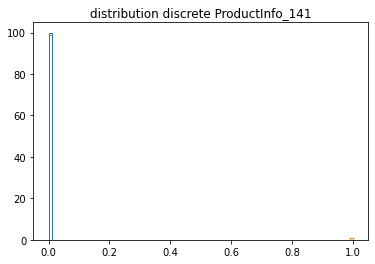

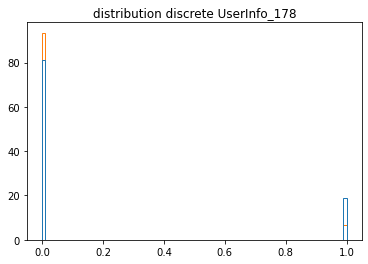

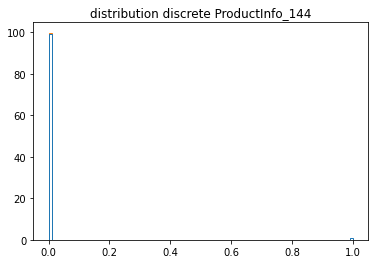

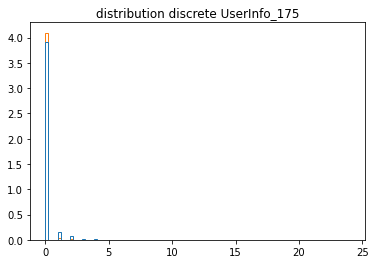

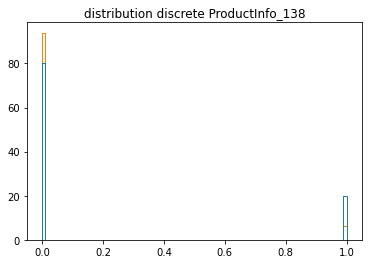

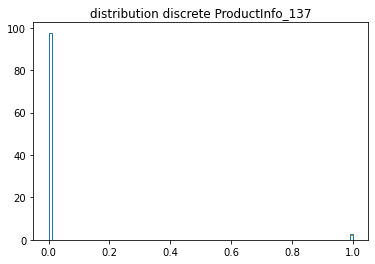

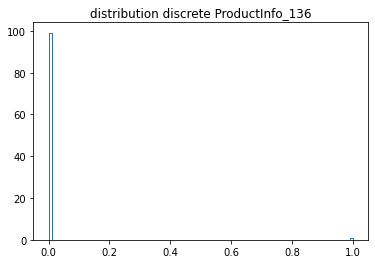

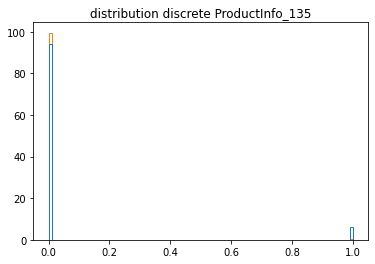

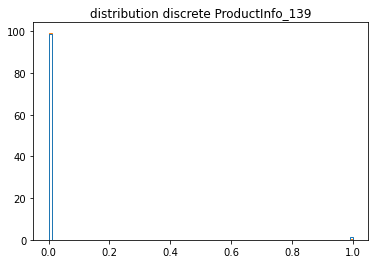

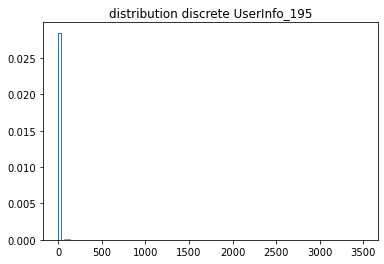

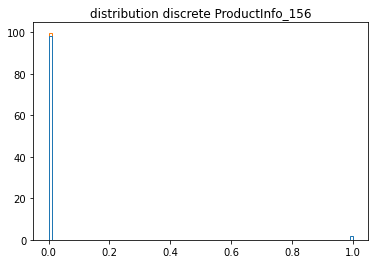

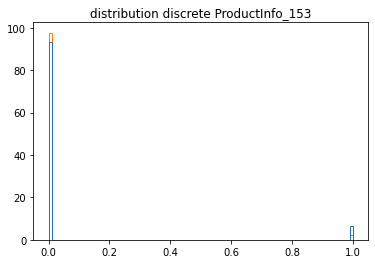

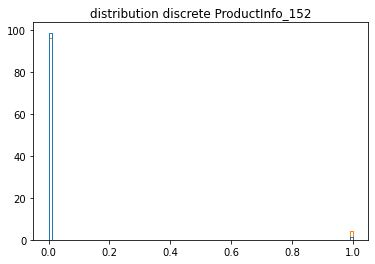

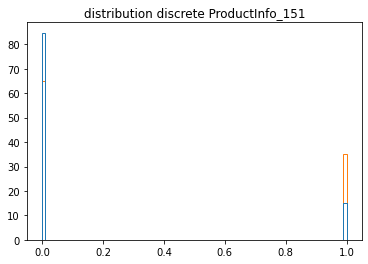

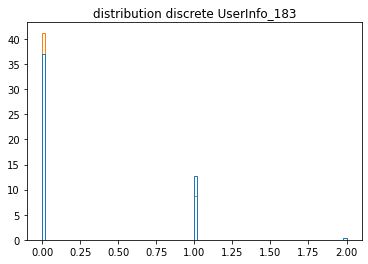

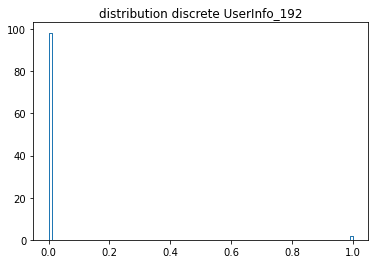

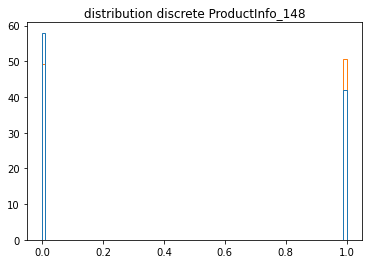

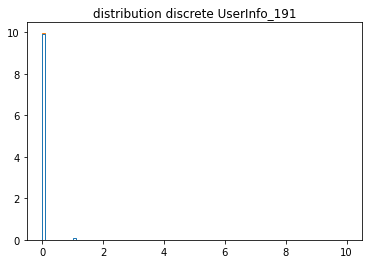

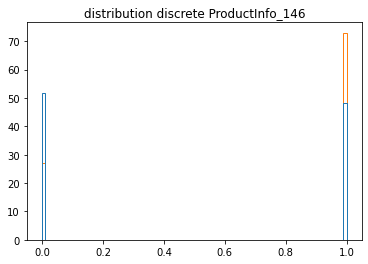

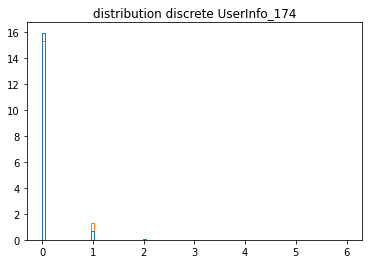

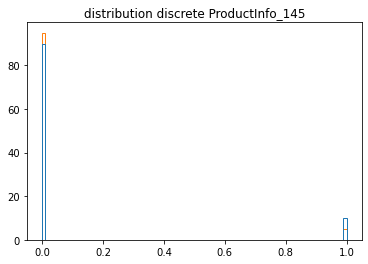

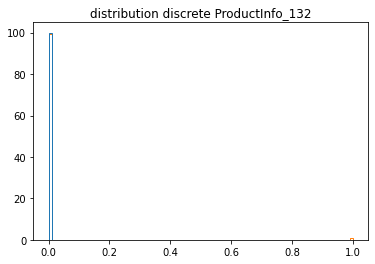

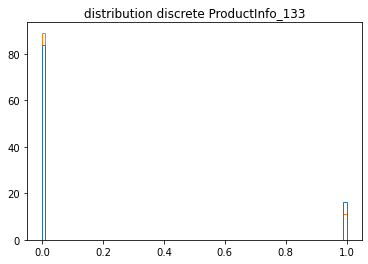

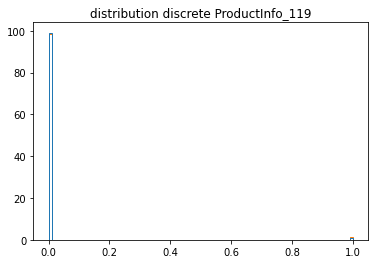

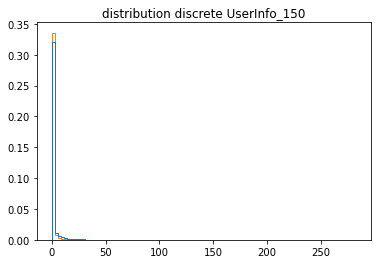

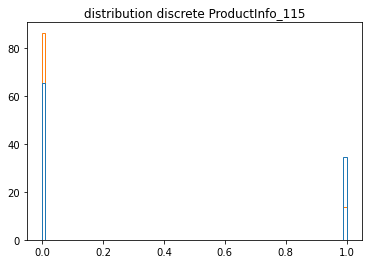

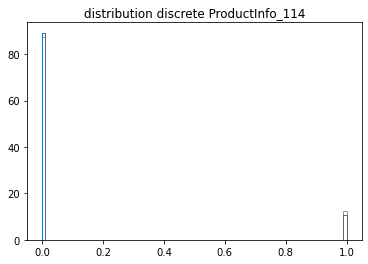

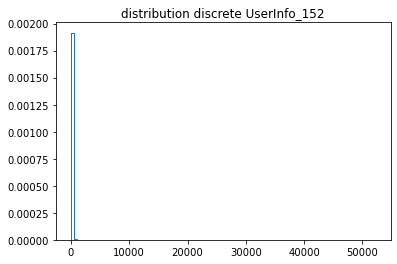

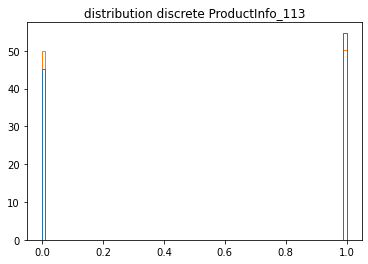

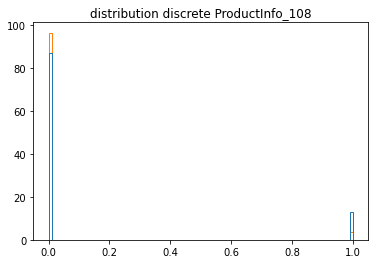

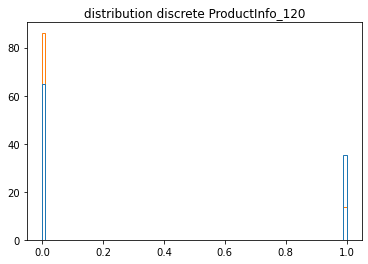

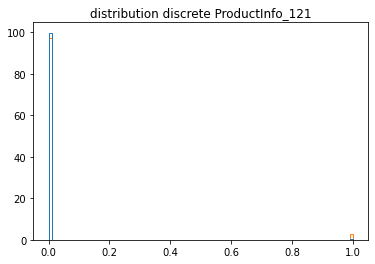

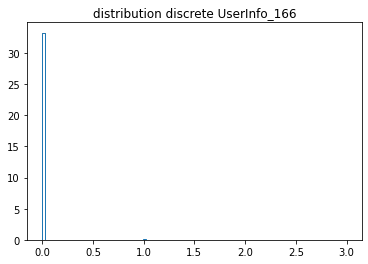

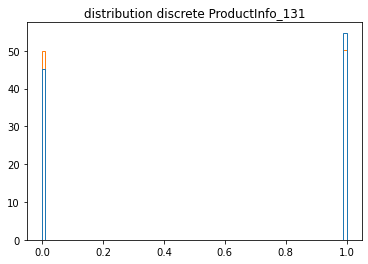

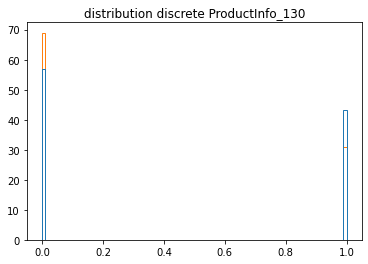

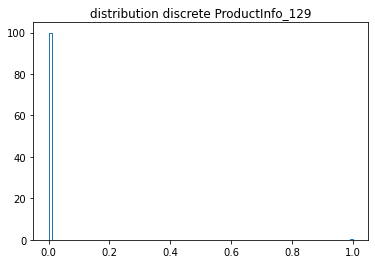

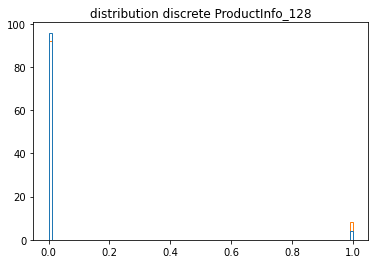

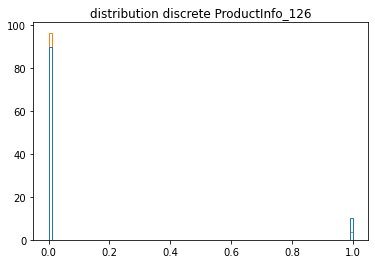

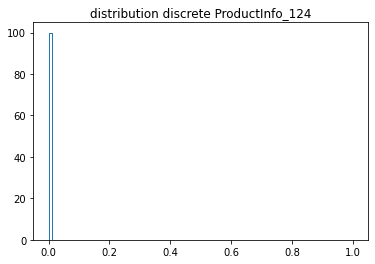

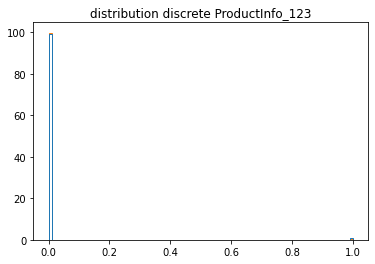

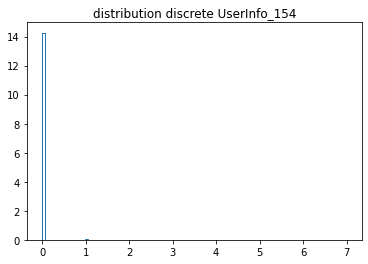

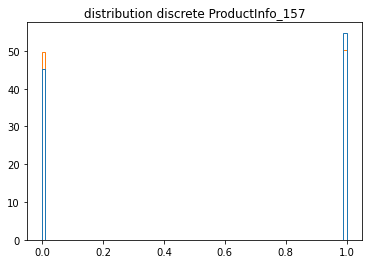

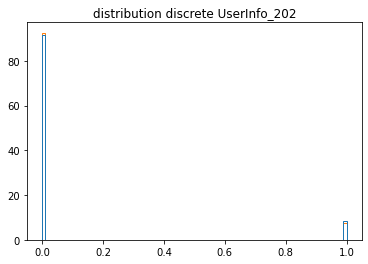

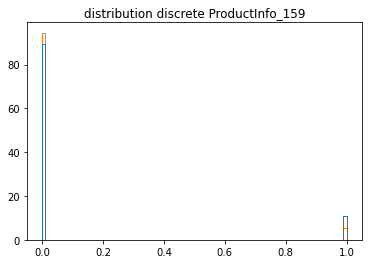

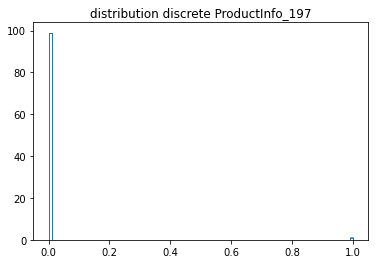

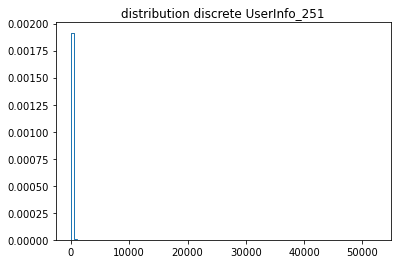

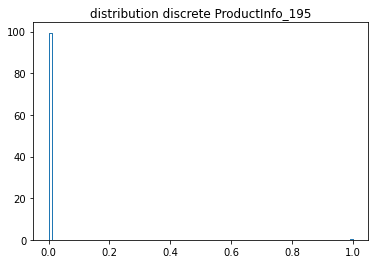

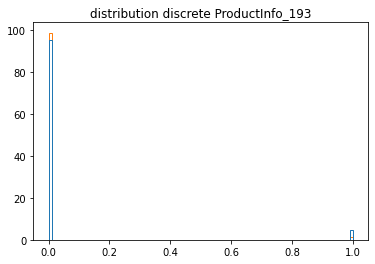

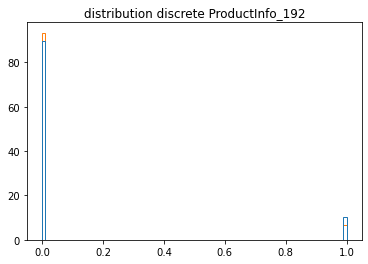

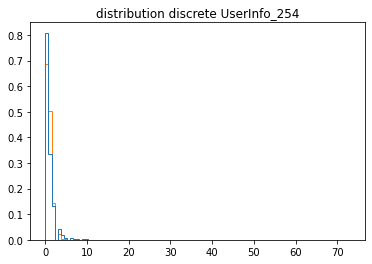

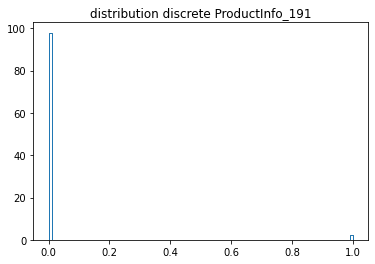

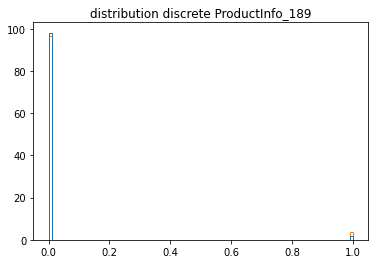

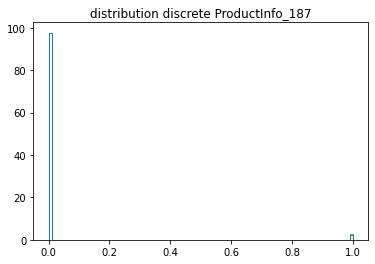

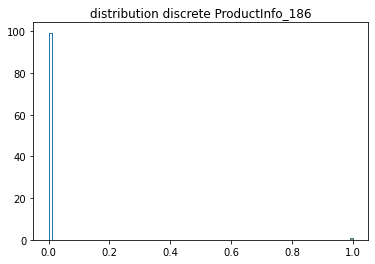

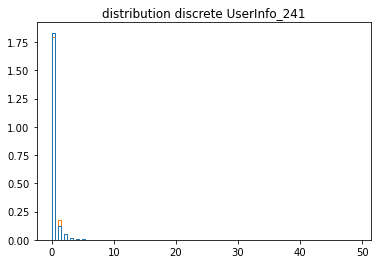

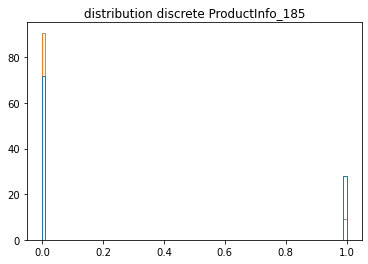

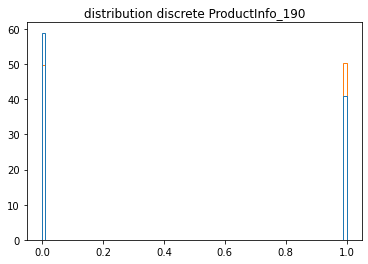

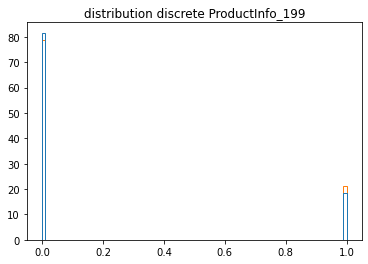

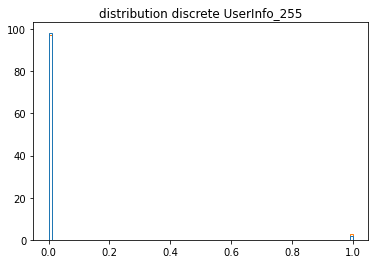

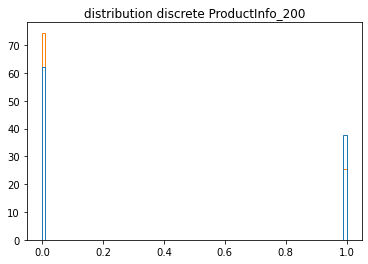

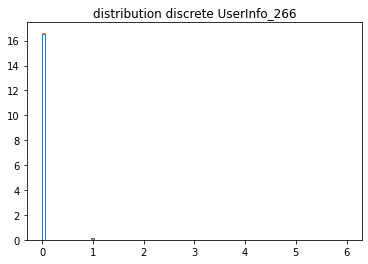

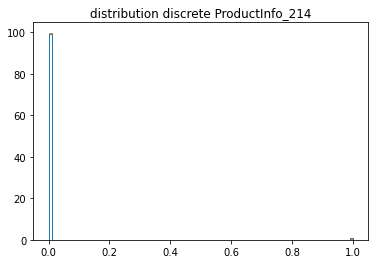

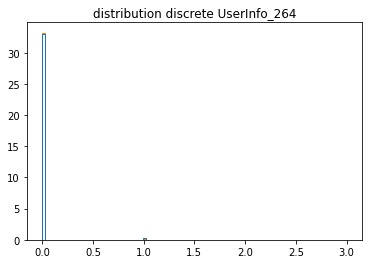

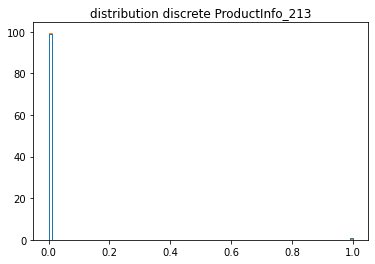

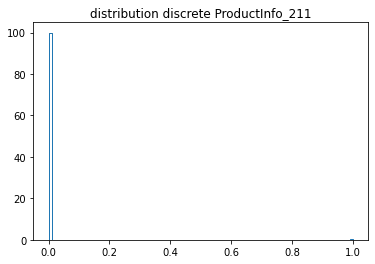

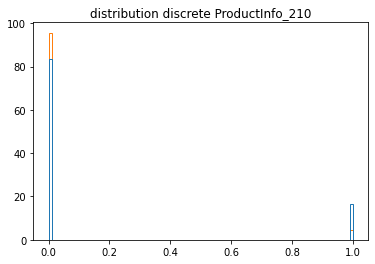

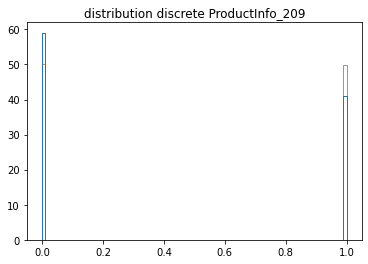

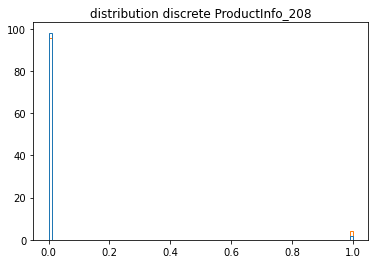

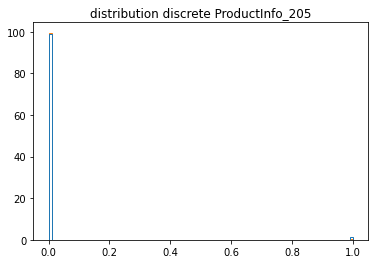

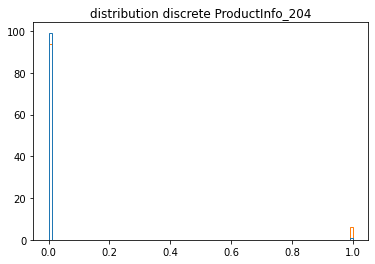

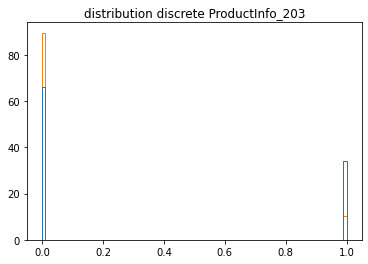

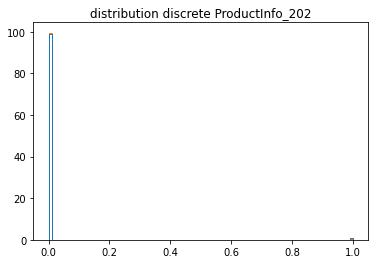

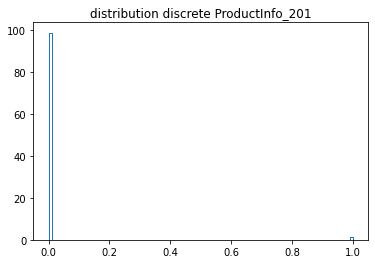

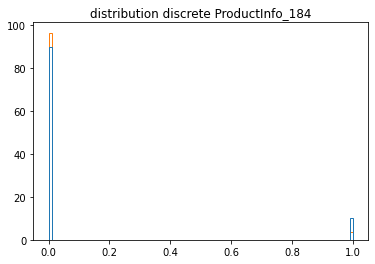

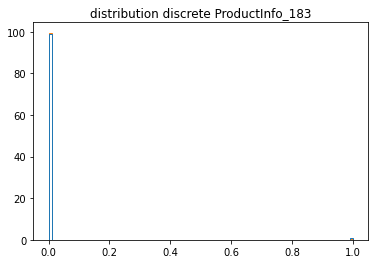

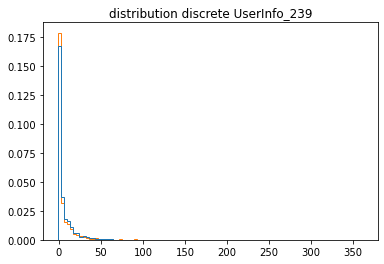

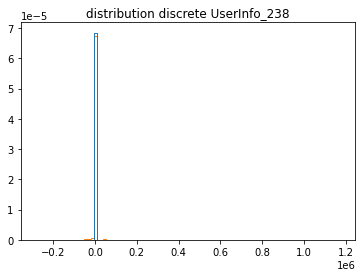

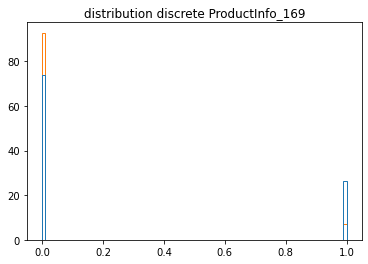

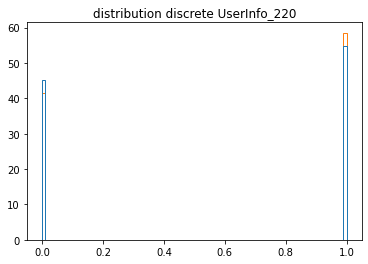

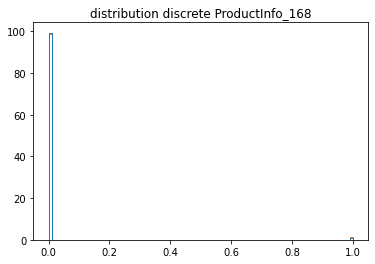

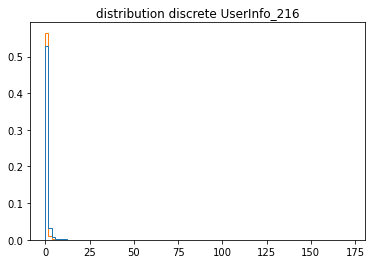

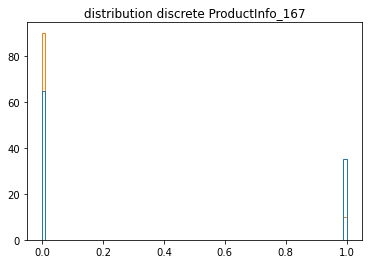

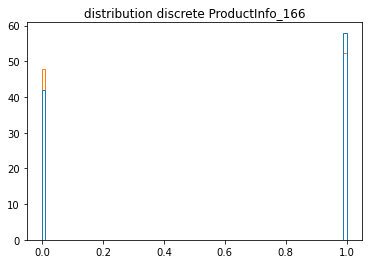

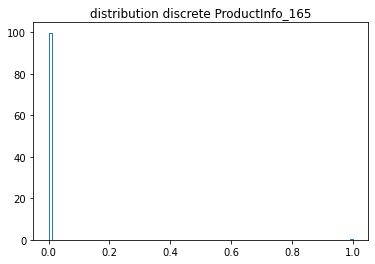

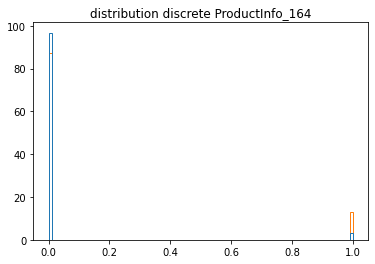

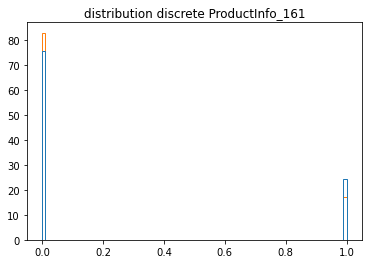

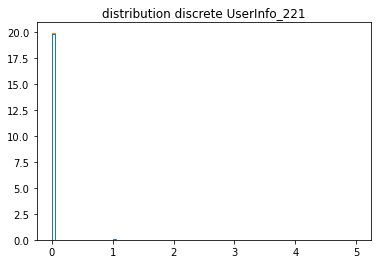

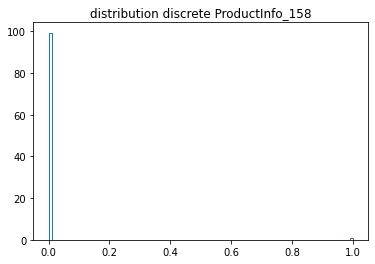

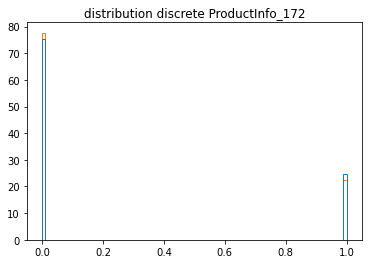

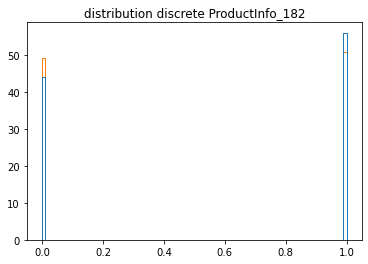

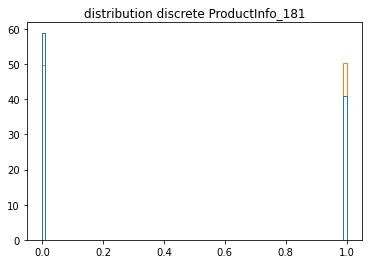

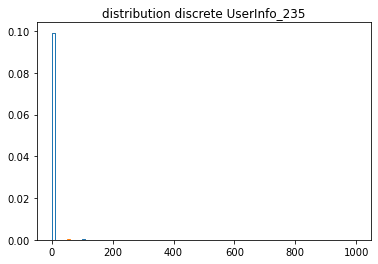

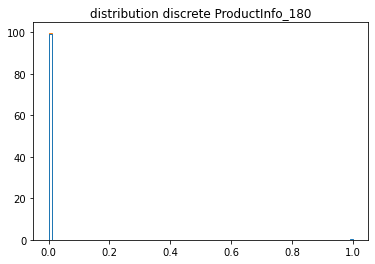

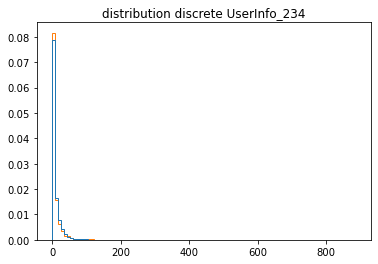

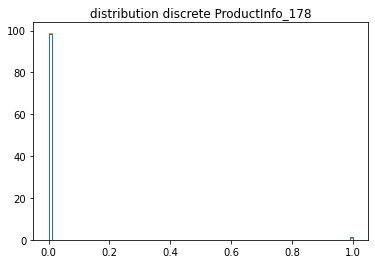

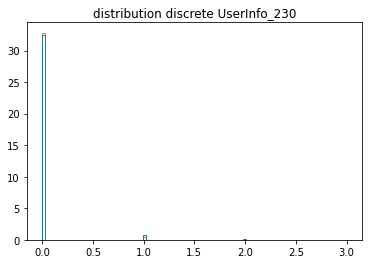

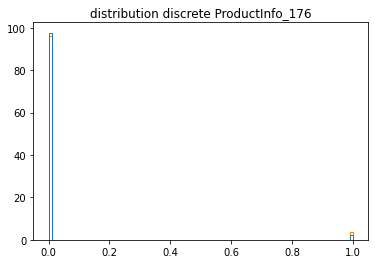

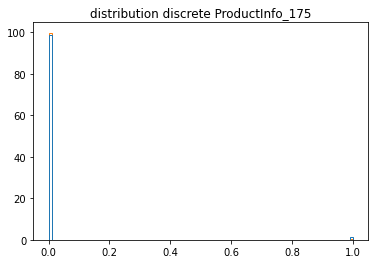

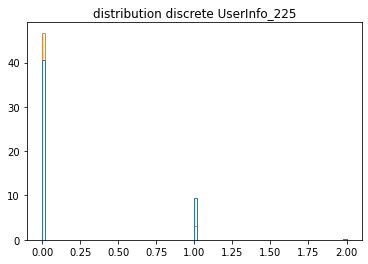

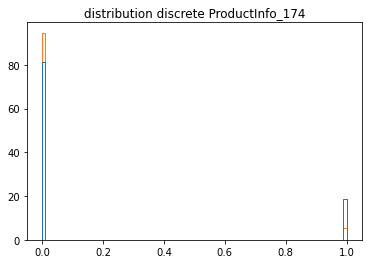

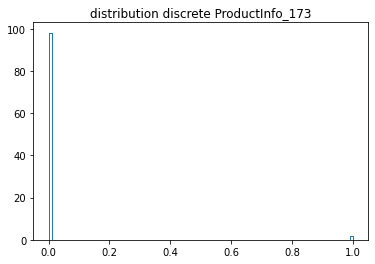

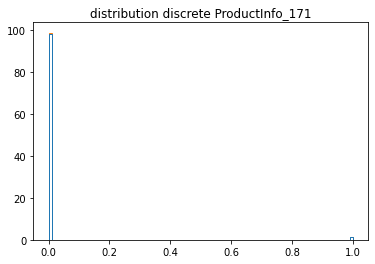

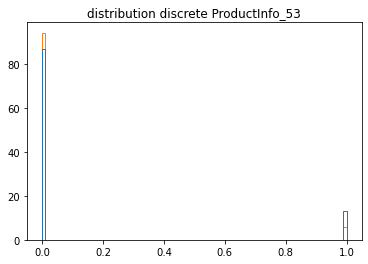

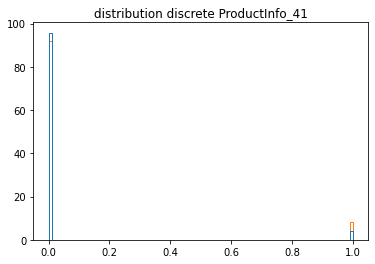

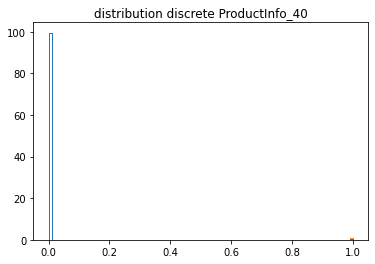

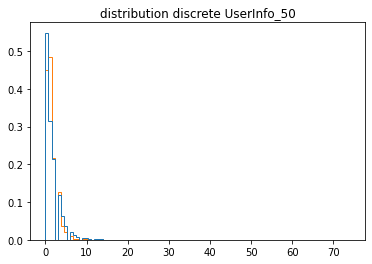

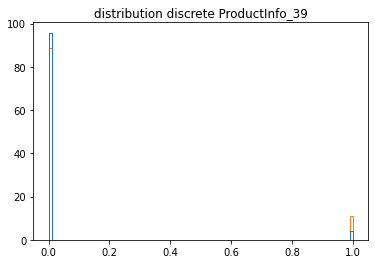

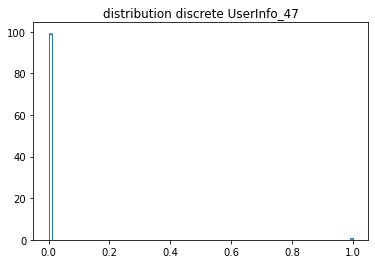

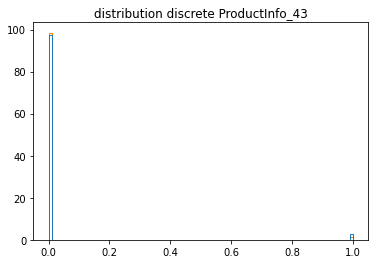

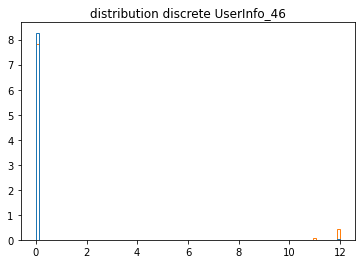

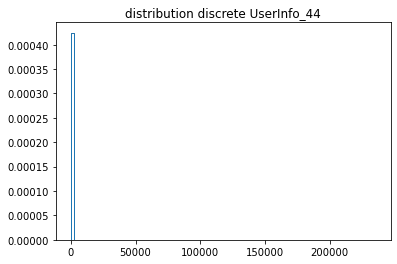

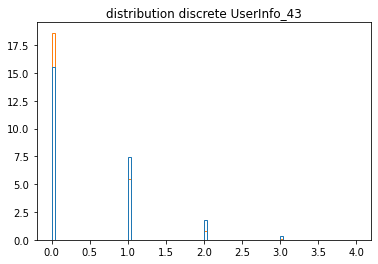

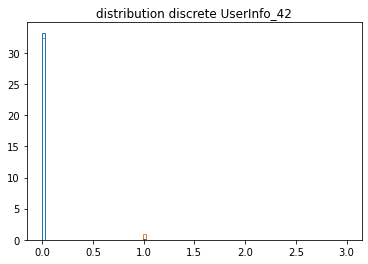

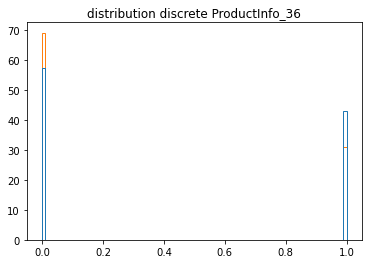

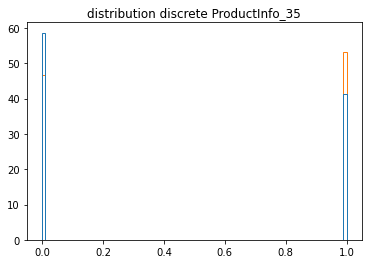

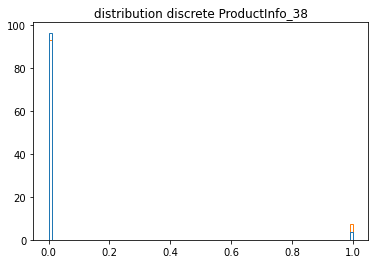

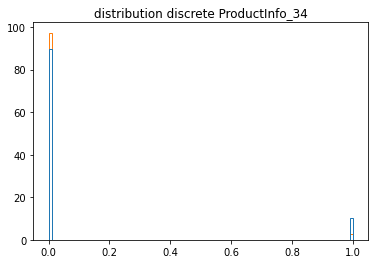

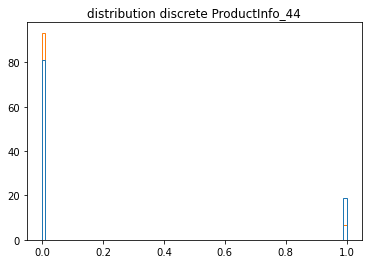

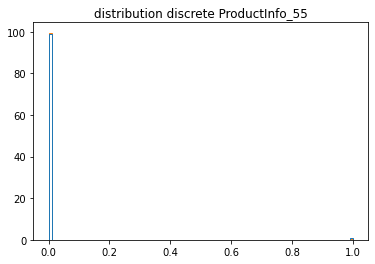

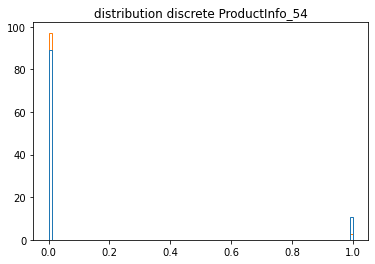

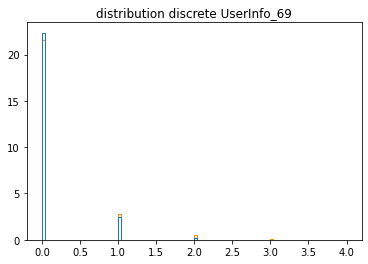

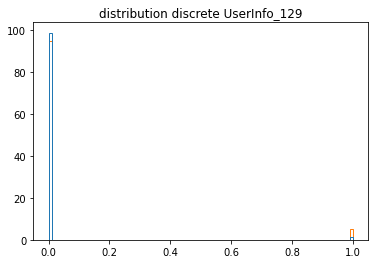

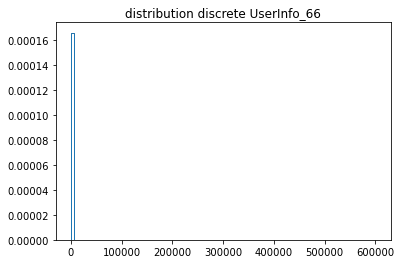

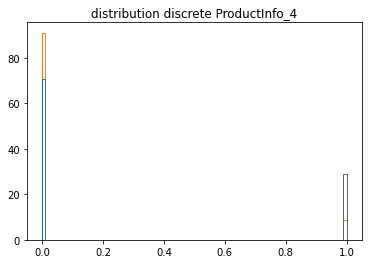

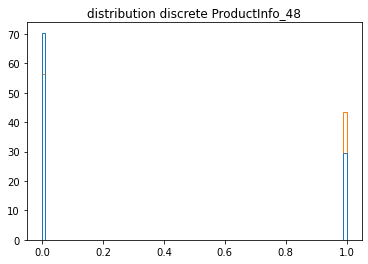

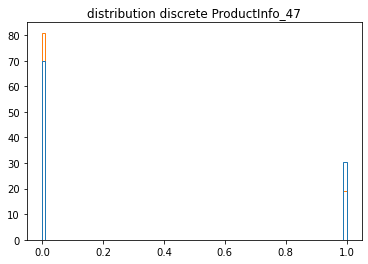

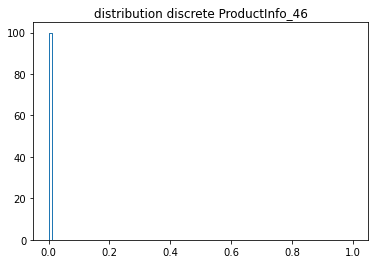

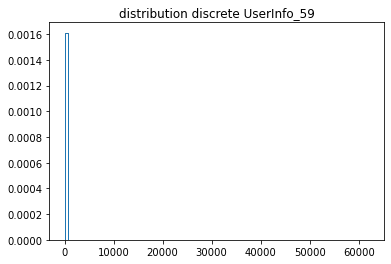

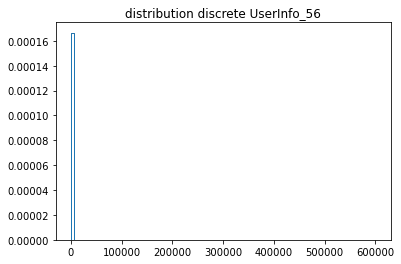

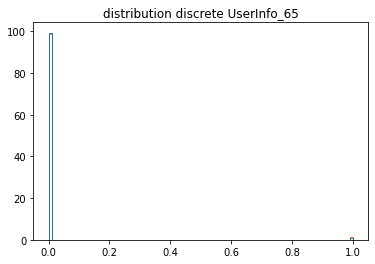

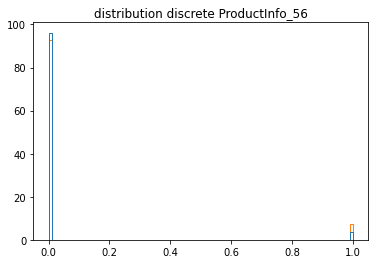

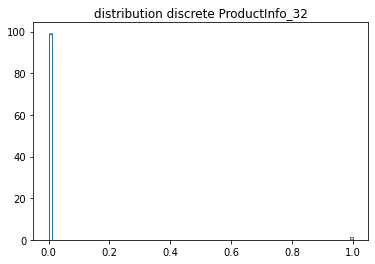

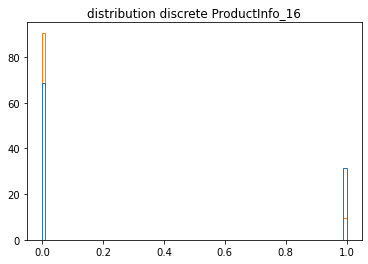

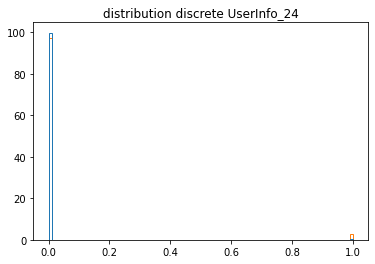

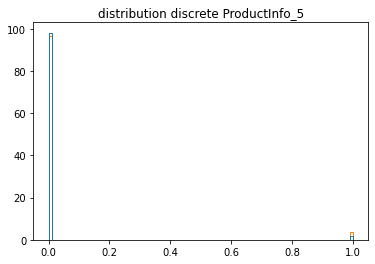

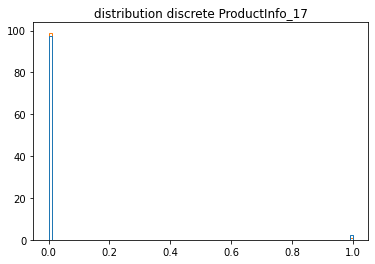

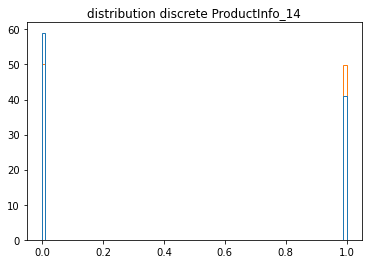

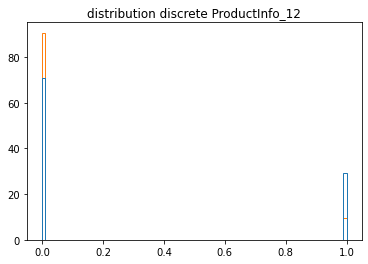

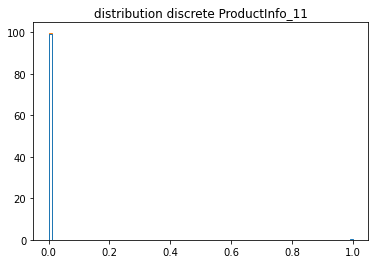

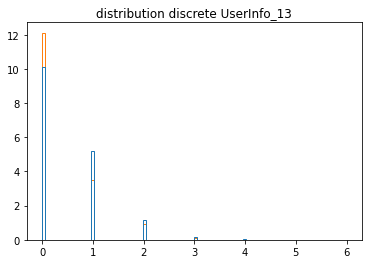

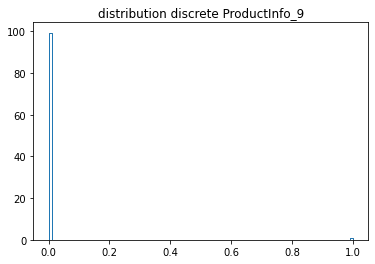

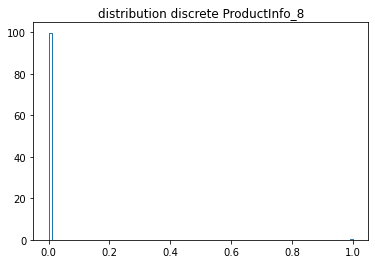

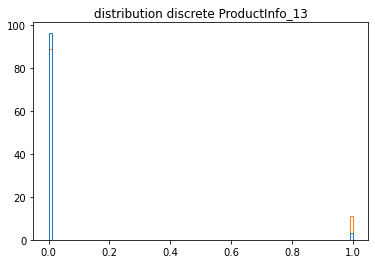

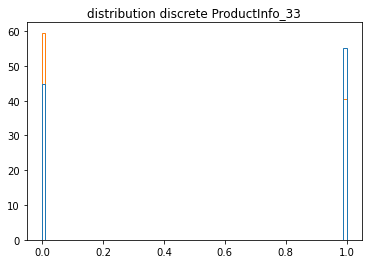

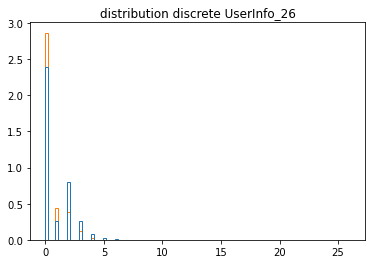

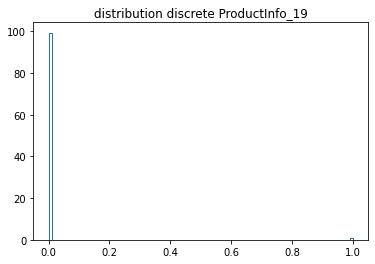

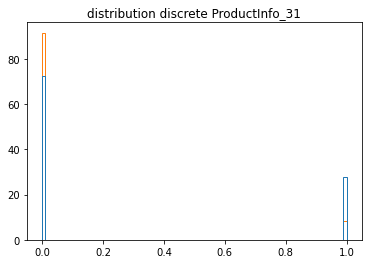

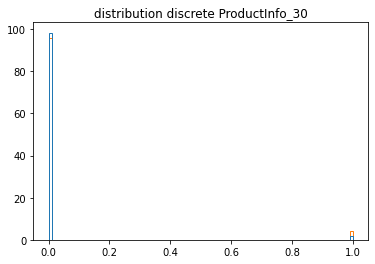

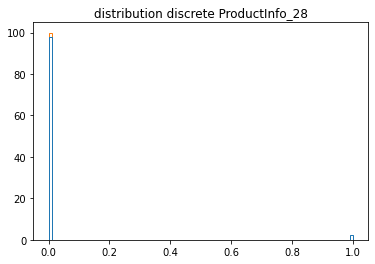

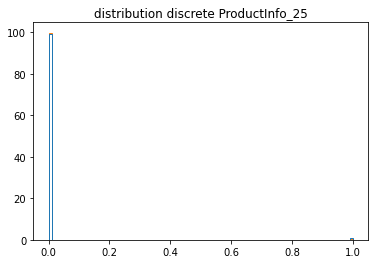

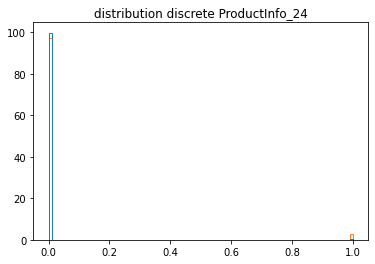

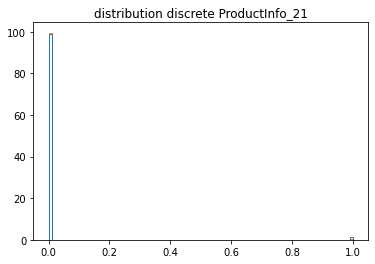

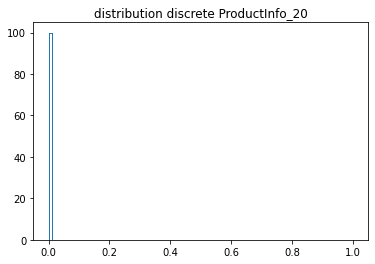

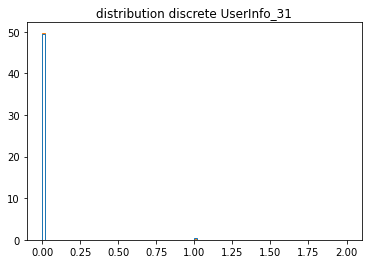

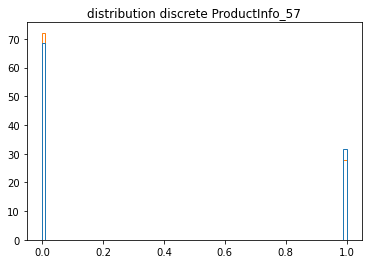

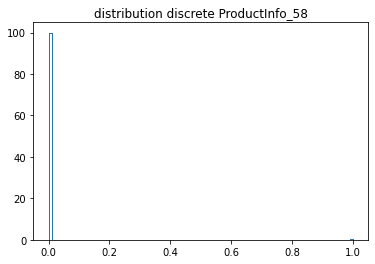

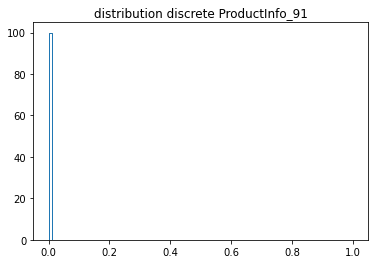

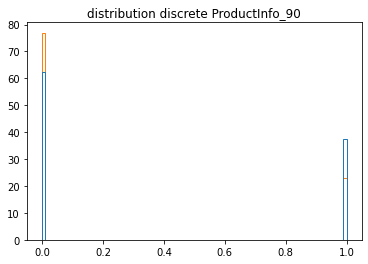

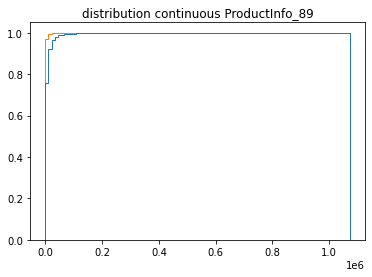

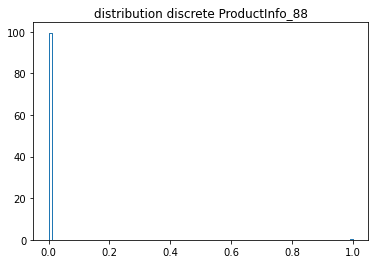

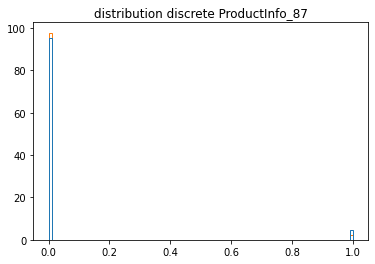

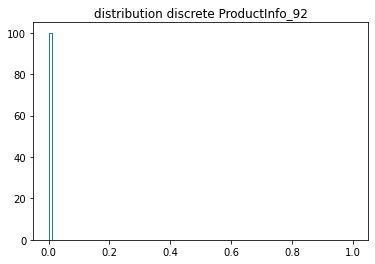

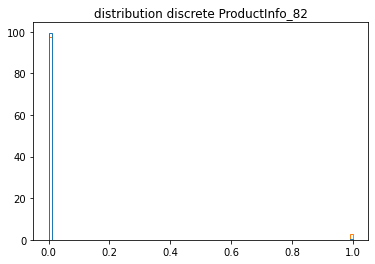

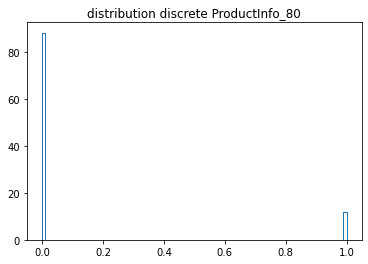

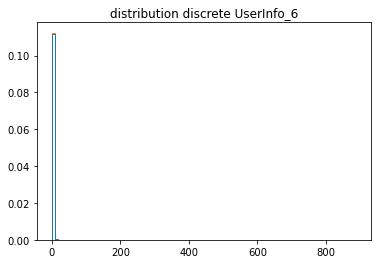

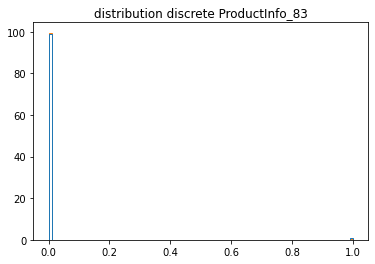

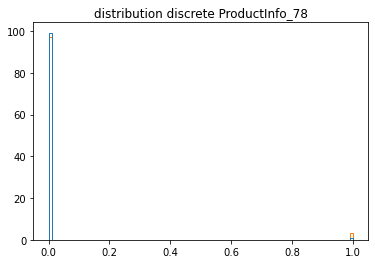

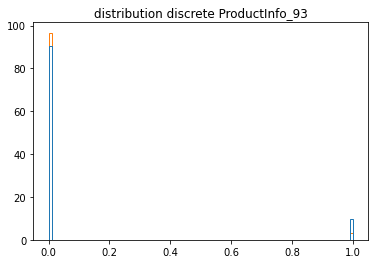

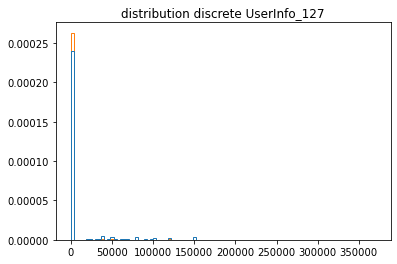

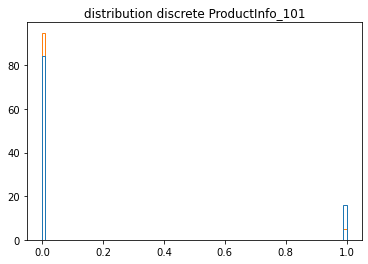

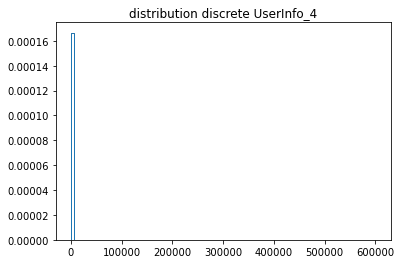

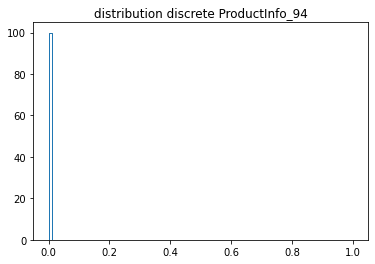

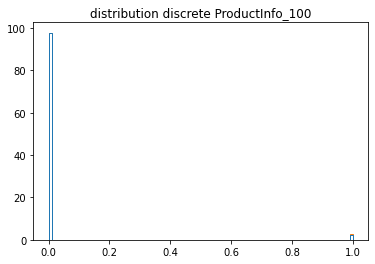

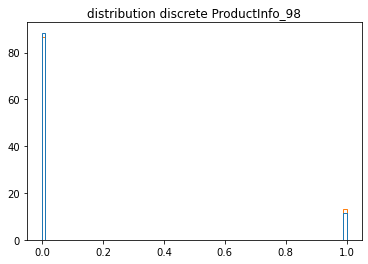

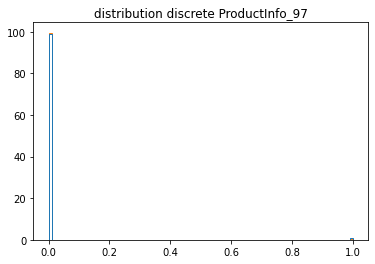

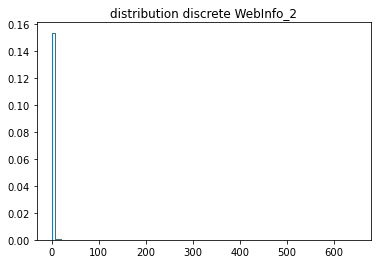

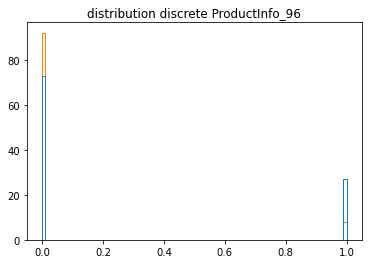

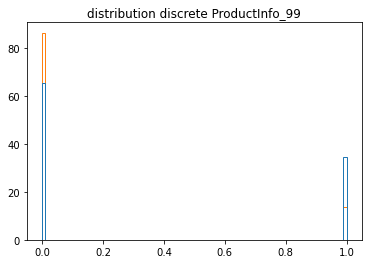

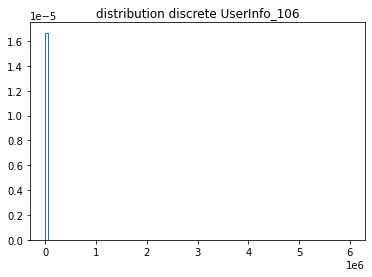

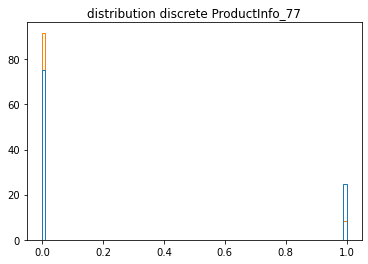

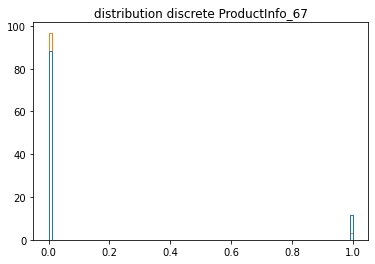

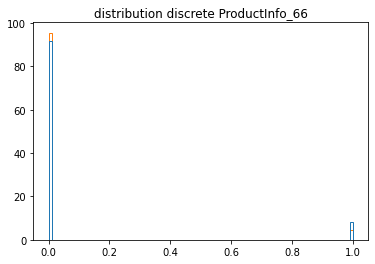

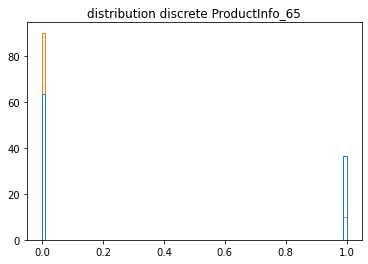

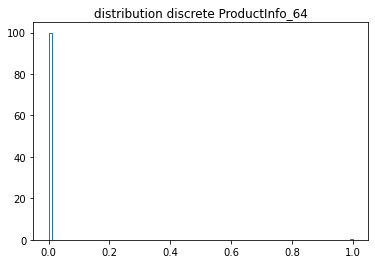

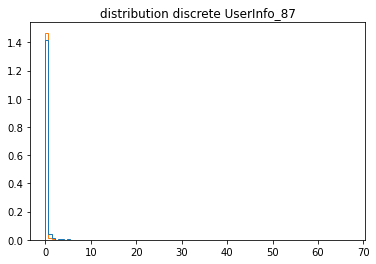

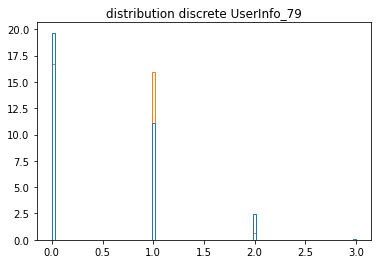

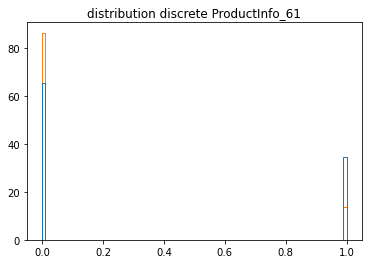

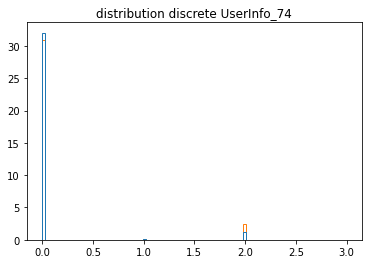

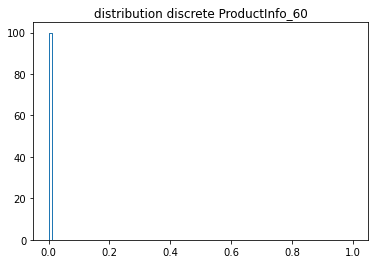

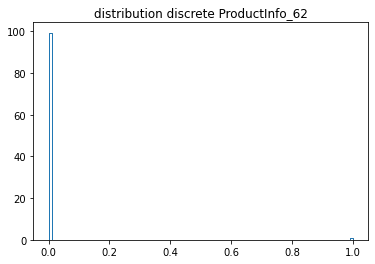

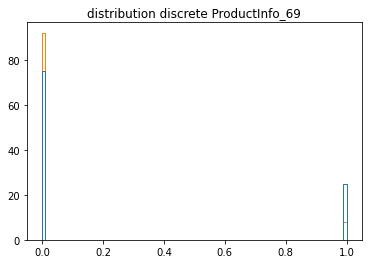

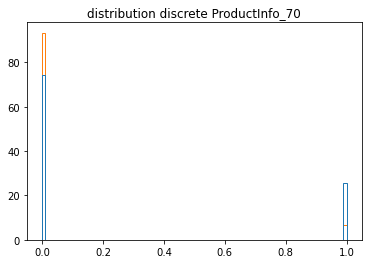

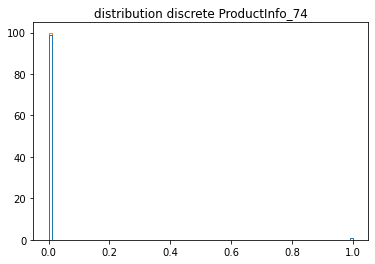

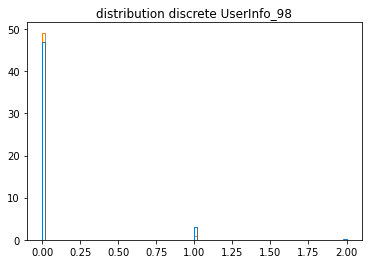

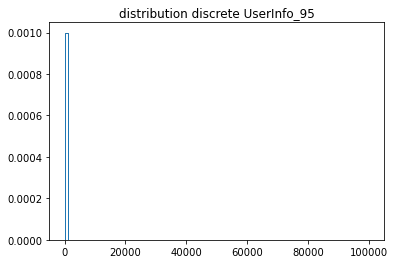

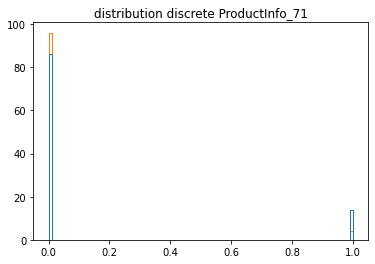

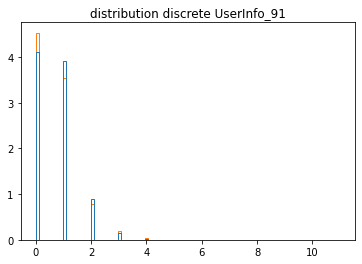

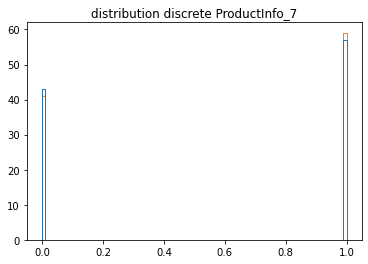

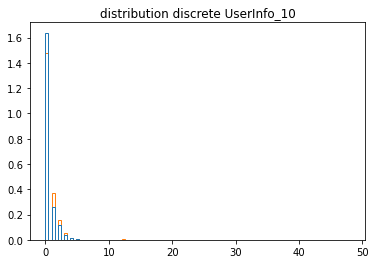

In [70]:

# 使用ks_2samp检测分布差异，
dis_b_diff = {};dis_ab_diff={};dis_abt_diff={}
for column in a_less_null_more_unique_columns.intersection(b_less_null_more_unique_columns):
    # print column
    dis_b_diff[column] = ks_2samp(b_standard_fillna_data[column].dropna(), test_standard_fillna_data[column].dropna())

    dis_ab_diff[column] = ks_2samp(b_standard_fillna_data[column].dropna(), a_standard_fillna_data[column].dropna())

    dis_abt_diff[column] = ks_2samp(test_standard_fillna_data[column].dropna(), a_standard_fillna_data[column].dropna())

dis_b_diff = pd.DataFrame.from_dict(dis_b_diff,orient='index')
dis_ab_diff = pd.DataFrame.from_dict(dis_ab_diff,orient='index')
dis_abt_diff = pd.DataFrame.from_dict(dis_abt_diff,orient='index')

# 缺失值少，且同分布的维度
print(dis_ab_diff[dis_ab_diff['statistic']<0.2])
for column in dis_ab_diff[dis_ab_diff['statistic']<0.2].index:
    if column in b_continuous_columns:
        title = 'distribution continuous '
        cumulative = True
    else:
        title = 'distribution discrete '
        cumulative = False
    plt.hist([a_data[column].dropna(),b_data[column].dropna()], cumulative=column in b_continuous_columns, density=True, bins=100,histtype='step')
    plt.title(title + column)
    #plt.savefig('../data/png_'+column+'_'+str(cumulative)+'_.png')
    plt.show()
#a_b_less_null_same_dis_columns = a_b_less_null_columns.intersection(dis_ab_same.index)
#a_data = a_data[less_null_columns]
#b_data = b_data[less_null_columns]
#test_data = test_data[less_null_columns.drop(['flag'])]


* 再次离散化

In [71]:
# 如何填充null值？？
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_mean.fit(a_data[all_continuous_columns])
# a_data[all_continuous_columns] = pd.DataFrame(imp_mean.transform(a_data[all_continuous_columns]),columns=all_continuous_columns)
# imp = IterativeImputer(max_iter=10, random_state=0)
# imp.fit(a_data[all_continuous_columns])
# b_data[all_continuous_columns] = pd.DataFrame(data=imp.transform(b_data[all_continuous_columns]),columns=all_continuous_columns)
# test_data['flag'] = np.nan
# test_data[all_continuous_columns] = pd.DataFrame(data=imp.transform(test_data[all_continuous_columns]),columns=all_continuous_columns)
# a_data[all_discrete_columns] = a_data[all_discrete_columns].fillna(1)
# b_data[all_discrete_columns] = b_data[all_discrete_columns].fillna(1)
# test_data[all_discrete_columns] = test_data[all_discrete_columns].fillna(1)
# a_data[all_discrete_columns] = a_data[all_discrete_columns].fillna(a_data[all_discrete_columns].mean())
# b_data[all_discrete_columns] = b_data[all_discrete_columns].fillna(a_data[all_discrete_columns].mean())
# test_data[all_discrete_columns] = test_data[all_discrete_columns].fillna(a_data[all_discrete_columns].mean())

# 离散化数据
tmp_continuous_columns = b_less_null_more_unique_columns.intersection(b_continuous_columns)
kbd = KBinsDiscretizer(n_bins=threshold_k_bins,encode='ordinal', strategy='uniform').fit(b_standard_fillna_data[tmp_continuous_columns])
b_standard_fillna_discrete_data = b_standard_fillna_data
test_standard_fillna_discrete_data = test_standard_fillna_data
b_standard_fillna_discrete_data[tmp_continuous_columns] = pd.DataFrame(kbd.transform(b_standard_fillna_data[tmp_continuous_columns]),columns=tmp_continuous_columns)
test_standard_fillna_discrete_data[tmp_continuous_columns] = pd.DataFrame(kbd.transform(test_standard_fillna_data[tmp_continuous_columns]),columns=tmp_continuous_columns)

b_standard_fillna_discrete_data.to_csv('../data/B_train_discrete.csv')
test_standard_fillna_discrete_data.to_csv('../data/B_test_discrete.csv')

* 异常值分析
    * https://www.cnblogs.com/tinglele527/p/11955103.html
    * https://scikit-learn.org/stable/modules/outlier_detection.html
    * https://scikit-learn.org/0.20/auto_examples/plot_anomaly_comparison.html
    * https://blog.csdn.net/PbGc396Dwxjb77F2je/article/details/99687952
    * 离散值中取值比例很小的这部分，可能有两种情况：对预测结果有强作用，对预测情况无影响，*可以做对比分析*
    * 离散值中，取值比例很小的部分，如果熵很大，说明本身对结果没有区分度，这部分异常值可能性很大，
    * 离散值中，条件熵大的维度，区分度小，这部分维度可能需要去除掉
    * 经过前面的同分布处理后，条件熵减少了很多，
    * 连续值中，box plot可以很方便观测处异常值
    * 连续值在A_train中异常值偏少，整体少于4%，是否需要处理？连续值在B_train中，整体异常值少于2.5%
    *

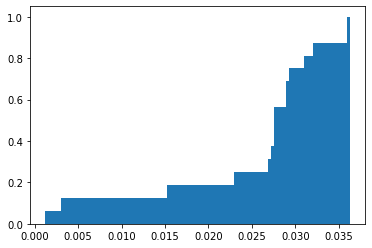

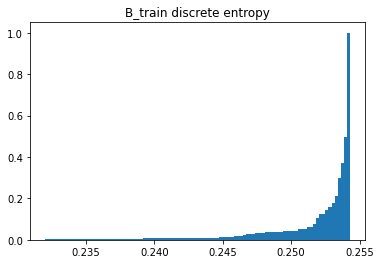

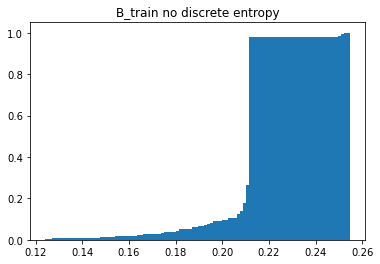

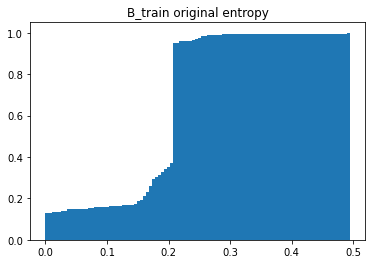

In [72]:
#标准差法 sunspots.counts > xbar + 2 * xstd
# a_continuous_data = a_data[all_continuous_columns]
# a_data_cont_abnormal = a_continuous_data > a_continuous_data.mean()+2*a_continuous_data.std()
# a_data_cont_abnormal_proportion = np.sum(a_data_cont_abnormal, axis=0)/a_data_cont_abnormal.shape[0]
# plt.hist(a_data_cont_abnormal_proportion, cumulative=True, bins=100, density=True);plt.show()

# 连续值中异常值的占比情况
tmp_continuous_data = b_standard_fillna_discrete_data[tmp_continuous_columns]
b_continuous_abnormal = tmp_continuous_data > tmp_continuous_data.mean()+2*tmp_continuous_data.std()
b_continuous_abnormal_proportion = np.sum(b_continuous_abnormal, axis=0)/b_continuous_abnormal.shape[0]
plt.hist(b_continuous_abnormal_proportion, cumulative=True, bins=100, density=True);plt.show()

# 维度与熵
b_discrete_entropy_dis = {}
b_no_discrete_entropy_dis = {}
count_threshold = b_data.shape[0] * 0.05
entropy_threshold = 0.5
# 每个维度的异常熵
least_count_entropy = {}
for column in b_less_null_more_unique_columns:
    s,d = conditional_entropy(b_standard_fillna_discrete_data, cond=column)
    s1,d1 = conditional_entropy(b_data, cond=column)
    b_discrete_entropy_dis[column] = s
    b_no_discrete_entropy_dis[column] = s1
    for v in d:
        # 离散值中，如果某个值的数量很少，单独存起来
        if d[v][1]<=count_threshold and d[v][0]>=entropy_threshold:
            if column not in least_count_entropy:
                least_count_entropy[column] = {}
            least_count_entropy[column][v] = d[v]
b_discrete_entropy_dis = pd.DataFrame.from_dict(b_discrete_entropy_dis, orient='index')
b_no_discrete_entropy_dis = pd.DataFrame.from_dict(b_no_discrete_entropy_dis, orient='index')
plt.hist(np.sort(b_discrete_entropy_dis, axis=0), bins=100, density=True, cumulative=True);plt.title('B_train discrete entropy');plt.show()
plt.hist(np.sort(b_no_discrete_entropy_dis, axis=0), bins=100, density=True, cumulative=True);plt.title('B_train no discrete entropy');plt.show()


b_original_entropy_dis = {}
for column in b_data:
    s,d = conditional_entropy(b_data, cond=column)
    b_original_entropy_dis[column] = s
b_original_entropy_dis = pd.DataFrame.from_dict(b_original_entropy_dis, orient='index')
plt.hist(np.sort(b_original_entropy_dis, axis=0), bins=100, density=True, cumulative=True);plt.title('B_train original entropy');plt.show()

* 经过以上分析，可以分布验证数据的处理情况
    * 排除null值多的维度
    * 取A B同分布维度，B_test + B_train = B
    * 剔除线性相关性强的维度
    * 数据离散化：sklearn
    * 排除条件熵大的维度
    * 填充null值：固定填充，根据分布填充
    * 数据规范化


In [73]:
#goon


target_bb = b_standard_fillna_discrete_data['flag']
bb_data = b_standard_fillna_discrete_data.drop('flag',axis=1)
bbt_data = test_standard_fillna_discrete_data


In [74]:
#   GBDT训练 输出（47%以上的特征）   ，训练集划分交叉验证

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bb_data, target_bb, test_size=0.3, random_state=0)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1,  max_depth=1, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
y_pro = clf.predict_proba(X_test)
y_prd = pd.DataFrame(y_pro).iloc[:,1]
roc_auc_score(y_test,y_prd)

# 训练所有数据 输出

clf.fit(bb_data,target_bb)
b = clf.predict_proba(bbt_data)
b=pd.DataFrame(b)
pro_b = b.iloc[:,1]
no = B_test.iloc[:,0]
pro = pd.DataFrame(pro_b)
no = pd.DataFrame(no)


# GBDT 重要特征

clf.fit(bb_data,target_bb)
clf_importance = clf.feature_importances_
clf_importance_ = pd.DataFrame(clf_importance)
clf_importance_.columns = {'importance'}
bb_columns = pd.DataFrame(bb_data.columns)
bb_columns.columns={'feature'}

#影响度排序
clf_feature_values = pd.concat([bb_columns,clf_importance_],axis=1)
clf_feature_values = clf_feature_values.sort_values(by='importance')


#影响度非0的特征
clf_feature_well = clf_feature_values[clf_feature_values['importance']!=0]
clf_feature_well_columns = clf_feature_well['feature'].values
clf_feature_well.index = clf_feature_well_columns
columns_GBDT = clf_feature_well.index

# 测试集提取这些特征，形成新的测试集

gbdt_b_data = B_train[columns_GBDT]
gbdt_bt_data = B_test[columns_GBDT]
gbdt_b_flag = pd.DataFrame(B_train['flag'])
gbdt_b_train = pd.concat([gbdt_b_data,gbdt_b_flag],axis=1)

gbdt_fillna_b_data = gbdt_b_data.fillna(0)
new_test_  = gbdt_bt_data.fillna(0)

In [75]:
#   重要特征训练，训练集交叉验证

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gbdt_fillna_b_data, gbdt_b_flag, test_size=0.3, random_state=0)
clf = GradientBoostingClassifier(n_estimators=110, learning_rate=1,  max_depth=1, random_state=0)#loss='exponential' mse
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
y_pro = clf.predict_proba(X_test)
y_prd = pd.DataFrame(y_pro).iloc[:,1]
roc_auc_score(y_test,y_prd)
clf.fit(gbdt_fillna_b_data,gbdt_b_flag)
b = clf.predict_proba(new_test_)
b=pd.DataFrame(b)
pro_b = b.iloc[:,1]
no = B_test.iloc[:,0]
pro = pd.DataFrame(pro_b)
no = pd.DataFrame(no)

/Users/wenqiang/opt/anaconda3/envs/qhzx37/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/wenqiang/opt/anaconda3/envs/qhzx37/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [76]:
import xgboost as xgb

xg_train = xgb.DMatrix(X_train,label=y_train)
xg_test = xgb.DMatrix(X_test,label=y_test)


param = {'booster':'gbtree',
         'max_depth':10,
         'eta':0.1,
         'silent':1,
         'objective':'binary:logistic',
         'eval_metric':'auc',
         'subsample': 1,
         "colsample_bytree": 0.7,
         "min_child_weight":2,
              'gamma':3.1,
              'lambda':1,
        "thread":-1,}
num_boost_round = 1500
watchlist = [(xg_train, 'train'), (xg_test, 'eval')]
num_round=15
bst = xgb.train(param, xg_train, num_round)
preds = bst.predict(xg_test)
roc_auc_score(y_test,preds)

xg_train = xgb.DMatrix(gbdt_fillna_b_data,label=gbdt_b_flag)
xg_test = xgb.DMatrix(new_test_)
bst = xgb.train(param, xg_train, num_round)
pro = bst.predict(xg_test)

xgb_model =xgb.cv(param,xg_train,num_boost_round,nfold=5, early_stopping_rounds=300)#, verbose_eval=True

pd.DataFrame(xgb_model)
# 0.5829
pd.DataFrame(xgb_model)['test-auc-mean'].mean()


0.58607725